<a href="https://colab.research.google.com/github/jsainero/BSS-Oslo/blob/master/TFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pathlib
import os
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta, date

# Carga de datos

In [3]:
from google.colab import drive
# drive.mount('/content/drive')
%cd /content/drive/MyDrive/UOC/TFM/

/content/drive/MyDrive/UOC/TFM


## Datos sobre los viajes

In [5]:
def count_trips(df, direction):
  
  if direction not in ('inbound','outbound'):
    raise Exception('Invalid value for direction')
  else:
    trip_time = 'started_at' if direction == 'outbound' else 'ended_at'
    trip_station = 'start_station_id' if direction == 'outbound' else 'end_station_id'
    df_filtered = df[[trip_time, trip_station, 'duration']]
    df_filtered[trip_time] = pd.to_datetime(df_filtered[trip_time])
    df_filtered['day'] = df_filtered[trip_time].dt.date
    df_filtered['hour'] = df_filtered[trip_time].dt.hour
    df_filtered = df_filtered[['day', 'hour', trip_station, 'duration']]
    df_filtered.columns = ['day', 'hour', 'station_id', 'duration']
    df_filtered['trips'] = 1
    df_grouped = df_filtered.groupby(['day', 'hour', 'station_id'], as_index=False).agg({'duration':'mean','trips':'sum'})
    
    return df_grouped

## Datos sobre las estaciones

In [6]:
def stations_data(df):

  column_names = ['id', 'name', 'latitude', 'longitude']
  df_filtered_outbound = df[['start_station_id','start_station_name','start_station_latitude', 'start_station_longitude']]
  df_filtered_inbound = df[['end_station_id','end_station_name','end_station_latitude', 'end_station_longitude']]
  df_filtered_outbound.columns = column_names
  df_filtered_inbound.columns = column_names
  df_filtered = df_filtered_outbound.append(df_filtered_inbound)

  return df_filtered.drop_duplicates()

## Datos sobre el tiempo atmosférico

In [7]:
from functools import reduce

def weather_phenomema_agg(x,y):
  if x == 'snow' or y == 'snow':
    return 'snow'
  elif x == 'rain' or y == 'rain':
    return 'rain'
  elif x == 'fog' or y == 'fog':
    return 'fog'
  else:
    return 'no phenomena'

def weather_phenomema_series(series):
  return reduce(lambda x, y: weather_phenomema_agg(x, y), series)

In [8]:
import pytz

def weather_data(filepath):

  df = pd.read_csv(filepath, sep=';', comment='#')
  df_cleaned = df.iloc[:,[0,1,6,8]]
  df_cleaned.columns = ['time','temperature','wind_speed', 'weather_phenomena']

  df_cleaned['weather_phenomena'] = df_cleaned['weather_phenomena'].fillna('no phenomena')
  df_cleaned['weather_phenomena'] = df_cleaned['weather_phenomena'].str.lower()
  df_cleaned.loc[df_cleaned['weather_phenomena'].str.contains('snow'),'weather_phenomena'] = 'snow'
  df_cleaned.loc[df_cleaned['weather_phenomena'].str.contains('rain|drizzle|thunderstorm|shower'),'weather_phenomena'] = 'rain'
  df_cleaned.loc[df_cleaned['weather_phenomena'].str.contains('fog|mist'),'weather_phenomena'] = 'fog'
  
  df_cleaned['time'] = pd.to_datetime(df_cleaned['time'], format='%d.%m.%Y %H:%M')
  df_cleaned = df_cleaned.set_index('time')
  df_cleaned.index = df_cleaned.index.tz_localize('Europe/Oslo', ambiguous='infer', nonexistent='shift_forward').tz_convert(pytz.utc).tz_convert(None)
  df_cleaned = df_cleaned.reset_index()
  df_cleaned.time = df_cleaned.time.dt.round('H')

  agg_dict = {
      'temperature':'mean',
      'wind_speed':'mean',
      'weather_phenomena':weather_phenomema_series
      }
  df_grouped = df_cleaned.groupby(['time'], as_index=False).agg(agg_dict)
  
  return df_grouped


## Lectura de datos

In [9]:
def read_monthly_data(filepath):

  df = pd.read_csv(filepath)
  df_outbounds = count_trips(df,'outbound')
  df_inbounds = count_trips(df,'inbound')
  df_stations = stations_data(df)

  return df_outbounds, df_inbounds, df_stations

In [10]:
def read_data(dirpath):

  df_outbounds = pd.DataFrame(columns=['day', 'hour', 'station_id', 'duration','trips'])
  df_inbounds = pd.DataFrame(columns=['day', 'hour', 'station_id', 'duration','trips'])
  df_stations = pd.DataFrame(columns=['id', 'name', 'latitude', 'longitude'])

  for year in os.scandir(dirpath+'/bike_trips'):
    for month in os.scandir(year):
      monthly_outbounds, monthly_inbounds, monthly_stations = read_monthly_data(month)
      df_outbounds = df_outbounds.append(monthly_outbounds)
      df_inbounds = df_inbounds.append(monthly_inbounds)
      df_stations = df_stations.append(monthly_stations)

  df_weather = weather_data(dirpath+'/weather/oslo_weather_20210101_20221031.csv')

  return df_outbounds, df_inbounds, df_stations.drop_duplicates().reset_index(drop=True), df_weather

In [11]:
DATA_DIR = 'data'

outbounds, inbounds, stations, weather = read_data(DATA_DIR) #Esto tarda 2 mins
display(outbounds.head(10))
display(stations.head(10))
display(weather.head(10))

,day,hour,station_id,duration,trips
0,2020-12-01,4,384,320.0,1
1,2020-12-01,4,444,500.0,1
2,2020-12-01,4,493,414.0,1
3,2020-12-01,4,511,828.0,1
4,2020-12-01,4,525,846.0,1
5,2020-12-01,4,540,258.0,1
6,2020-12-01,4,597,315.0,1
7,2020-12-01,4,607,442.0,1
8,2020-12-01,5,377,388.0,1
9,2020-12-01,5,383,695.5,2


,id,name,latitude,longitude
0,540,Lilleborgbanen,59.933632,10.769118
1,511,Henrik Ibsens gate,59.915088,10.722280
2,525,Myraløkka Øst,59.937205,10.760581
3,597,Fredensborg,59.920995,10.750358
4,384,Vår Frelsers gravlund sør,59.919463,10.743829
5,607,Marcus Thranes gate,59.932772,10.758595
6,444,AHO,59.925265,10.750462
7,493,Sofienbergparken nordvest,59.924364,10.761586
8,563,Huitfeldts gate,59.912684,10.722900
9,489,Torggata,59.915983,10.751551


,time,temperature,wind_speed,weather_phenomena
0,2020-12-31 23:00:00,-2.0,3.0,snow
1,2021-01-01 00:00:00,-2.0,3.0,snow
2,2021-01-01 01:00:00,-2.0,2.5,snow
3,2021-01-01 02:00:00,-2.0,3.0,snow
4,2021-01-01 03:00:00,-2.0,3.0,snow
5,2021-01-01 04:00:00,-2.0,3.0,snow
6,2021-01-01 05:00:00,-2.0,3.0,snow
7,2021-01-01 06:00:00,-2.0,3.0,snow
8,2021-01-01 07:00:00,-2.0,3.0,snow
9,2021-01-01 08:00:00,-2.0,3.0,snow


# Análisis descriptivo año 2021

- Análisis por:
  - [x] hora y día
  - [x] mes
  - [x] día
  - [x] hora
  - [x] dia de la semana
  - [x] temperaura
  - [x] fenómeno temporal

- Análisis de estaciones con más diferencia entre outbound e inbound por hora

- Añadir el clima y comparar con la duración de los viajes

- Mostrar en un mapa inbounds y outbounds de estaciones (opc)



## Añadir columnas relevantes

In [12]:
def enhance_df(df):
  df_enhanced = df[(df.day >= pd.to_datetime('2021-01-01').date())
            & (df.day <= pd.to_datetime('2021-12-31').date())]

  df_enhanced['day_hour'] =  pd.to_datetime(df_enhanced['day']) + pd.to_timedelta(df_enhanced['hour'], unit='h')
  df_enhanced['weekday'] = df_enhanced['day_hour'].dt.weekday
  df_enhanced['year'] = df_enhanced['day_hour'].dt.year
  df_enhanced['month'] = df_enhanced['day_hour'].dt.month
  df_enhanced['day_of_month'] = df_enhanced['day_hour'].dt.day
  df_enhanced = df_enhanced.merge(weather, how='left', left_on='day_hour', right_on='time')
  df_enhanced = df_enhanced[['day_hour','day','hour','station_id','duration','trips','weekday','day_of_month', 'month', 'year', 'temperature','wind_speed','weather_phenomena']]
  
  return df_enhanced

In [13]:
outbounds_enhanced = enhance_df(outbounds)
inbounds_enhanced = enhance_df(inbounds)
outbounds_enhanced.head()

,day_hour,day,hour,station_id,duration,trips,weekday,day_of_month,month,year,temperature,wind_speed,weather_phenomena
0,2021-12-01 04:00:00,2021-12-01,4,420,807.0,2,2,1,12,2021,-16.5,1.5,fog
1,2021-12-01 04:00:00,2021-12-01,4,421,1035.0,1,2,1,12,2021,-16.5,1.5,fog
2,2021-12-01 04:00:00,2021-12-01,4,444,368.0,1,2,1,12,2021,-16.5,1.5,fog
3,2021-12-01 04:00:00,2021-12-01,4,470,788.0,1,2,1,12,2021,-16.5,1.5,fog
4,2021-12-01 04:00:00,2021-12-01,4,503,285.0,1,2,1,12,2021,-16.5,1.5,fog


## Gráficas

In [ ]:
def two_var_graphs(df, x, y, agg_fn='sum'):

  df_filtered = df[[x,y]]
  df_grouped = df_filtered.groupby([x], as_index=False).agg({y: agg_fn})
  df_grouped.plot(x=x, y=y)
  plt.show()

### Viajes

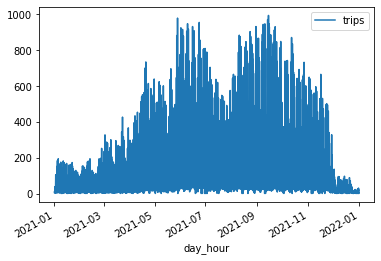

In [ ]:
two_var_graphs(outbounds_enhanced, 'day_hour', 'trips', 'sum')

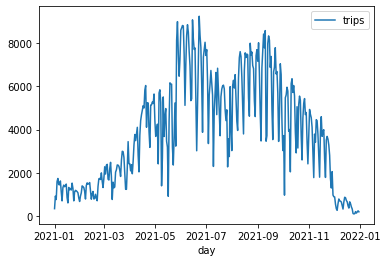

In [ ]:
two_var_graphs(outbounds_enhanced, 'day', 'trips', 'sum')

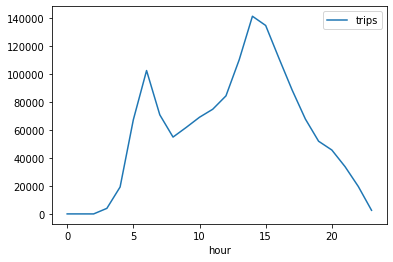

In [ ]:
two_var_graphs(outbounds_enhanced, 'hour', 'trips', 'sum')

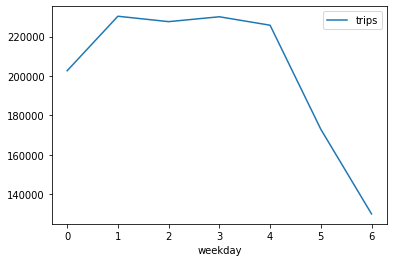

In [ ]:
two_var_graphs(outbounds_enhanced, 'weekday', 'trips', 'sum')

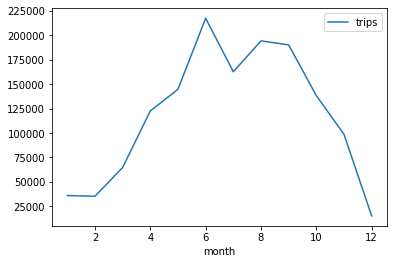

In [ ]:
two_var_graphs(outbounds_enhanced, 'month', 'trips', 'sum')

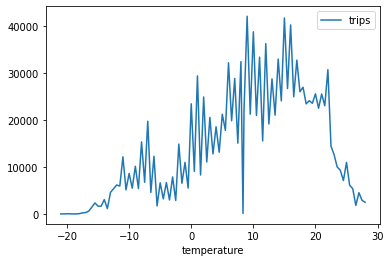

In [ ]:
two_var_graphs(outbounds_enhanced, 'temperature', 'trips', 'sum')

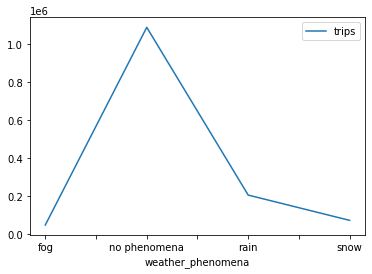

In [ ]:
two_var_graphs(outbounds_enhanced, 'weather_phenomena', 'trips', 'sum')

### Duración

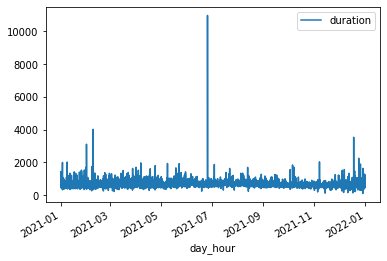

In [ ]:
two_var_graphs(outbounds_enhanced, 'day_hour', 'duration', 'mean')

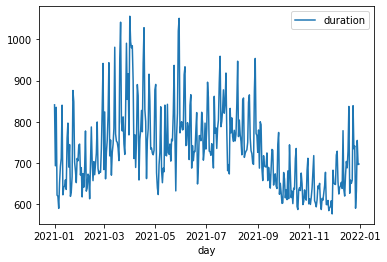

In [ ]:
two_var_graphs(outbounds_enhanced, 'day', 'duration', 'mean')

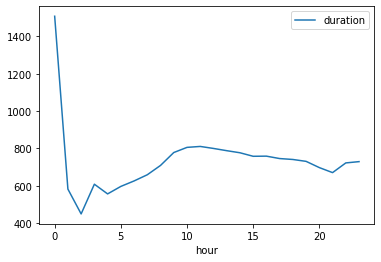

In [ ]:
two_var_graphs(outbounds_enhanced, 'hour', 'duration', 'mean')

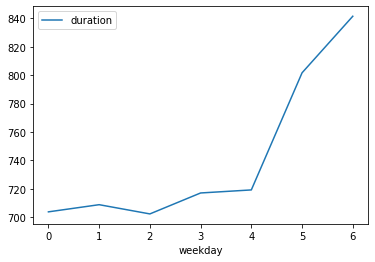

In [ ]:
two_var_graphs(outbounds_enhanced, 'weekday', 'duration', 'mean')

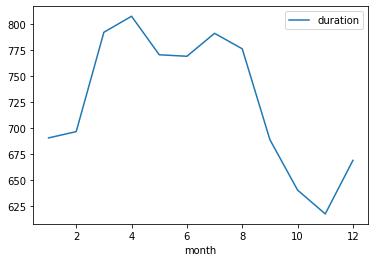

In [ ]:
two_var_graphs(outbounds_enhanced, 'month', 'duration', 'mean')

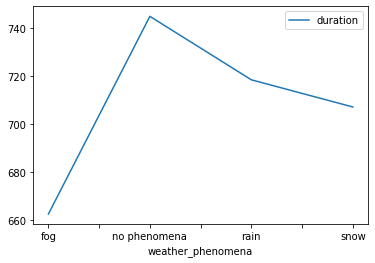

In [ ]:
two_var_graphs(outbounds_enhanced, 'weather_phenomena', 'duration', 'mean')

## Estaciones más especiales

In [ ]:
outbounds_by_station = outbounds_enhanced.groupby(['station_id']).agg({'trips':'sum'})
inbounds_by_station = inbounds_enhanced.groupby(['station_id']).agg({'trips':'sum'})
trips_by_station = outbounds_by_station.merge(inbounds_by_station, on='station_id', suffixes=("_outbound", "_inbound"))
trips_by_station['total_trips'] = trips_by_station['trips_outbound'] + trips_by_station['trips_inbound']
trips_by_station['diff_trips'] = trips_by_station['trips_outbound'] - trips_by_station['trips_inbound']
trips_by_station.head()

,trips_outbound,trips_inbound,total_trips,diff_trips
station_id,,,,
377,4825,4857,9682,-32
378,3637,3631,7268,6
380,9227,5396,14623,3831
381,7179,8761,15940,-1582
382,4603,4573,9176,30


### Estación más transitada

Definimos como estación más transitada aquella en la que se dejan y se cogen más bicicletas.

In [ ]:
trips_by_station.sort_values(by='total_trips', ascending=False).head()

,trips_outbound,trips_inbound,total_trips,diff_trips
station_id,,,,
421,19655,19644,39299,11
551,17731,21178,38909,-3447
398,18162,18185,36347,-23
494,12357,21208,33565,-8851
489,11997,20455,32452,-8458


### Estación menos transitada

In [ ]:
trips_by_station.sort_values(by='total_trips', ascending=True).head()

,trips_outbound,trips_inbound,total_trips,diff_trips
station_id,,,,
2329,8,5,13,3
2330,31,29,60,2
2328,74,116,190,-42
566,114,114,228,0
1919,593,410,1003,183
560,809,416,1225,393
2309,812,489,1301,323
2306,957,562,1519,395
571,799,983,1782,-184


### Estación más desbalanceada por exceso de salidas

In [ ]:
trips_by_station.sort_values(by='diff_trips', ascending=True).head()

,trips_outbound,trips_inbound,total_trips,diff_trips
station_id,,,,
494,12357,21208,33565,-8851
489,11997,20455,32452,-8458
495,5450,13374,18824,-7924
599,4250,12091,16341,-7841
611,5299,13068,18367,-7769


### Estación más desbalanceadas por exceso de entradas

In [ ]:
trips_by_station.sort_values(by='diff_trips', ascending=False).head()

,trips_outbound,trips_inbound,total_trips,diff_trips
station_id,,,,
397,12321,5410,17731,6911
391,10050,4268,14318,5782
582,10217,4883,15100,5334
420,7858,2974,10832,4884
383,7662,3080,10742,4582


### Estación promedio

In [ ]:
def distance_to_mean(element, df):
  mean = df.mean()
  dist = 0
  for i in range(len(element)):
    dist += np.power(element[i] - mean[i], 2)
  
  return np.sqrt(dist)

In [ ]:
trips_by_station['distance_to_mean'] = trips_by_station.apply(lambda station: distance_to_mean(station, trips_by_station), axis=1)
trips_by_station.mean()

trips_outbound     5417.114504
trips_inbound      5417.114504
total_trips       10834.229008
diff_trips            0.000000
dtype: float64

In [ ]:
trips_by_station.sort_values(by='distance_to_mean', ascending=True).head()

,trips_outbound,trips_inbound,total_trips,diff_trips,distance_to_mean
station_id,,,,,
414,5414,5447,10861,-33,52.043530
455,5480,5503,10983,-23,184.371126
457,5506,5498,11004,8,208.156875
435,5534,5587,11121,-53,357.169292
422,5204,5197,10401,7,530.664263


# Modelos

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

In [27]:
weather_phen_dict={
    'no phenomena': 0,
    'rain': 1,
    'fog': 2,
    'snow': 3
}

columns = ['day_of_month', 'month', 'year', 'hour', 'duration','weekday', 'temperature', 'wind_speed', 'weather_phenomena', 'trips']
outbound_station = outbounds_enhanced[outbounds_enhanced.station_id == 414][columns].replace({'weather_phenomena': weather_phen_dict}).sort_values(by=['year','month', 'day_of_month', 'hour'])
inbound_station = outbounds_enhanced[outbounds_enhanced.station_id == 414][columns].replace({'weather_phenomena': weather_phen_dict}).sort_values(by=['year','month', 'day_of_month', 'hour'])

outbound_station.head(100)

,day_of_month,month,year,hour,duration,weekday,temperature,wind_speed,weather_phenomena,trips
92693,2,1,2021,9,281.0,5,-1.0,3.0,3,1
92967,2,1,2021,14,405.0,5,-1.0,2.5,3,2
93475,3,1,2021,11,844.0,6,-5.5,2.5,0,1
93709,3,1,2021,15,3760.0,6,-6.0,1.5,0,1
94218,4,1,2021,8,310.0,0,-8.5,3.0,0,1
...,...,...,...,...,...,...,...,...,...,...
67266,2,2,2021,21,436.0,1,-8.0,4.0,3,1
67863,3,2,2021,14,433.0,2,-9.0,4.5,0,1
67956,3,2,2021,15,328.0,2,-10.5,4.5,0,1
69022,4,2,2021,15,352.5,3,-10.5,4.5,0,2


In [31]:
TRAIN_SIZE=3*len(outbound_station)//4

outbound_train = outbound_station[:TRAIN_SIZE]
outbound_test = outbound_station[TRAIN_SIZE:]
outbound_train_X = outbound_train.drop(columns = "trips")
outbound_train_y = outbound_train["trips"]
outbound_test_X = outbound_test.drop(columns = "trips")
outbound_test_y = outbound_test["trips"]


## Random forest

In [32]:
RANDOM_STATE = 27

rf_outbounds = RandomForestRegressor(
            n_estimators=10,
            criterion='squared_error',
            max_depth=None,
            random_state=RANDOM_STATE
         )

In [34]:
rf_outbounds.fit(outbound_train_X, outbound_train_y)

RandomForestRegressor(n_estimators=10, random_state=27)

In [35]:
predicciones = rf_outbounds.predict(X = outbound_test_X)

rmse = mean_squared_error(
        y_true  = outbound_test_y,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 1.2875869618522071
